In [19]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# import custom functions from src/utils.py
import sys
sys.path.append('../')
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca
from src.utils import plot_feature_importances
from src.utils import confusion_matrix_heatmap
from src.search_space_config import create_search_space

In [20]:
digits = load_digits()

In [21]:
digits.data[2]

array([ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
       14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
        1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
        0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  3., 13., 16.,
       16., 11.,  5.,  0.,  0.,  0.,  0.,  3., 11., 16.,  9.,  0.])

In [22]:
digits.data.shape

(1797, 64)

In [23]:
# convert the data to a pandas dataframe
import pandas as pd
df = pd.DataFrame(digits.data, columns=['feature_' + str(i) for i in range(1, 65)])

# add the target column to the dataframe
df['target'] = digits.target

# check the head of the dataframe
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [24]:
features_df = df.drop('target', axis=1)
target_df = df['target']

In [25]:
features_df.shape

(1797, 64)

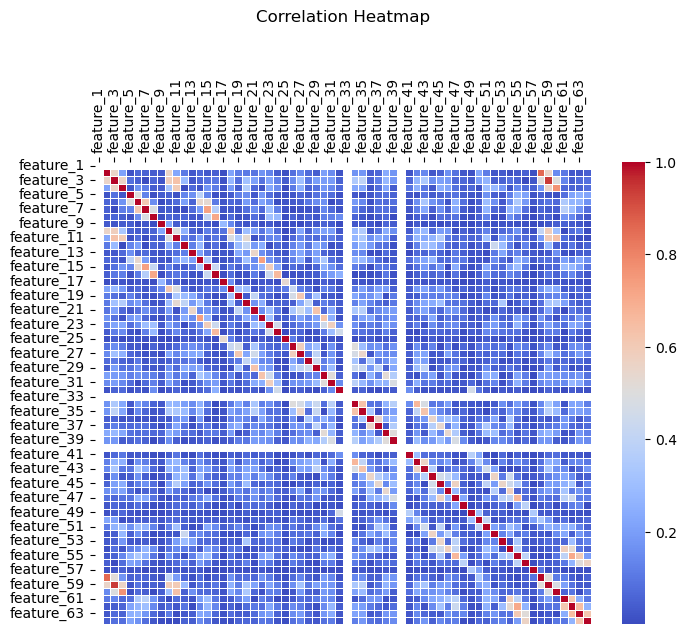

In [26]:
plot_correlation_heatmap(features_df, annot=False)

In [27]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(1797, 63)


In [28]:
# Check for balance in the target variable
target_df.value_counts()

target
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

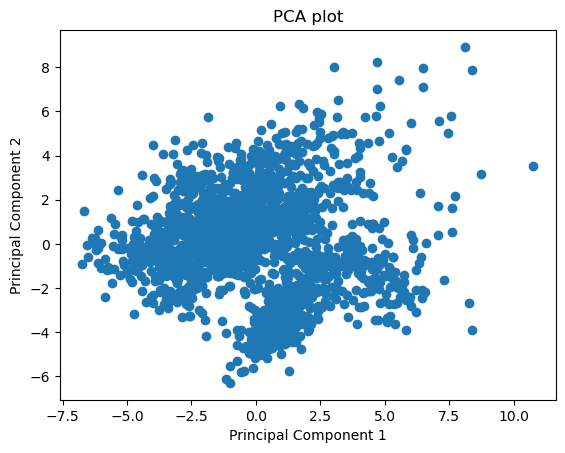

In [29]:
plot_pca(features_df)

In [30]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(1797, 48)


,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_11,feature_12,feature_13,...,feature_52,feature_53,feature_54,feature_55,feature_58,feature_60,feature_61,feature_62,feature_63,feature_64
0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,13.0,15.0,10.0,...,5.0,10.0,12.0,0.0,0.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,11.0,16.0,...,16.0,16.0,6.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,4.0,15.0,12.0,0.0,0.0,3.0,16.0,15.0,...,16.0,16.0,11.0,5.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,7.0,15.0,13.0,1.0,0.0,8.0,13.0,6.0,15.0,...,4.0,5.0,14.0,9.0,0.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,7.0,8.0,...,3.0,15.0,10.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [31]:
# Scale the features using MaxMinScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

In [32]:
X = scaled_features_df
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:

# Use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000, multi_class='auto',  solver='lbfgs', tol=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9666666666666667


<h2 style="color:blue" align="center">Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ol>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ol>

In [34]:
n_features = features_df.shape[1]
search_space = create_search_space(n_features)

In [36]:

# Objective function to minimize
def objective(params):
    model_name = params['model']['type']
    del params['model']['type']
    
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params['model'])
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params['model'], max_iter=1000)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params['model'])
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(**params['model'],verbosity=-1)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**params['model'], verbose=False)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params['model'])
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params['model'])
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(**params['model'])
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params['model'])
    elif model_name == 'ExtraTreesClassifier':
        model = ExtraTreesClassifier(**params['model'])

    model_pipeline = make_pipeline(
        PolynomialFeatures(degree=params['polynomialfeatures_degree']),
        SelectKBest(f_regression, k=params['selectkbest_k']),
        model
    )
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss')
    log_loss_cv = -scores.mean() 
    
    return {
        'loss': log_loss_cv,
        'status': STATUS_OK,
        'model_pipeline': model_pipeline,
    }

trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=150, trials=trials)

100%|██████████| 150/150 [19:10<00:00,  7.67s/trial, best loss: 0.10699970918419917] 


In [37]:
best_params = space_eval(search_space, best)
best_params

{'model': {'learning_rate': 0.17417865964786383,
  'max_depth': 3,
  'n_estimators': 110,
  'num_leaves': 33,
  'type': 'LGBMClassifier'},
 'polynomialfeatures_degree': 1,
 'selectkbest_k': 20}

<h2 style="color:blue" align="center">Model Re-training, Inference, Evaluation and Saving</h2>

In this section, I will re-train with the best model and hyper-paramaters from the previous secction. This section will include:
<ol>
    <li>Model Re-training</li>
    <li>Feature Importance</li>
    <li>Model Saving</li>
</ol>

In [38]:
best_params['model']

{'learning_rate': 0.17417865964786383,
 'max_depth': 3,
 'n_estimators': 110,
 'num_leaves': 33,
 'type': 'LGBMClassifier'}

In [39]:
# Rebuild the pipeline with the best parameters
best_model_name = best_params['model']['type']
del best_params['model']['type']

if best_model_name == 'RandomForestClassifier':
    best_model = RandomForestClassifier(**best_params['model'])
elif best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**best_params['model'])
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(**best_params['model'])
elif best_model_name == 'LGBMClassifier':
    best_model = LGBMClassifier(**best_params['model'],verbosity=-1, force_row_wise=True)
elif best_model_name == 'CatBoostClassifier':
    best_model = CatBoostClassifier(**best_params['model'], verbose=False)
elif best_model_name == 'GaussianNB':
    best_model = GaussianNB()
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(**best_params['model'])
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(**best_params['model'])
elif best_model_name == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(**best_params['model'])
elif best_model_name == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(**best_params['model'])
elif best_model_name == 'ExtraTreesClassifier':
    best_model = ExtraTreesClassifier(**best_params['model'])


# Create the pipeline with the best parameters
best_model_pipeline = make_pipeline(
    PolynomialFeatures(degree=best_params['polynomialfeatures_degree']),  # Use the best degree
    SelectKBest(f_regression, k=best_params['selectkbest_k']),  # Use the best k features
    best_model
)

In [40]:
# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x000002E4CCBAB3A0>)),
                ('lgbmclassifier',
                 LGBMClassifier(force_row_wise=True,
                                learning_rate=0.17417865964786383, max_depth=3,
                                n_estimators=110, num_leaves=33,
                                verbosity=-1))])

In [41]:
best_model_pipeline.score(X_test, y_test)

0.95

In [42]:
y_pred = best_model_pipeline.predict(X_test)

In [43]:
selected_features_indices = best_model_pipeline.named_steps['selectkbest'].get_support(indices=True)
poly = best_model_pipeline.named_steps['polynomialfeatures']
transformed_feature_names = poly.get_feature_names_out(input_features=features_df.columns)
# map the selected indices to the transformed feature names
selected_features = transformed_feature_names[selected_features_indices]
selected_features

array(['feature_6', 'feature_7', 'feature_13', 'feature_15', 'feature_21',
       'feature_26', 'feature_28', 'feature_29', 'feature_30',
       'feature_34', 'feature_36', 'feature_37', 'feature_38',
       'feature_42', 'feature_51', 'feature_52', 'feature_53',
       'feature_54', 'feature_61', 'feature_64'], dtype=object)

In [44]:
# Get the feature importances
if best_model_name == 'RandomForestClassifier':
    feature_importances = best_model_pipeline.named_steps['randomforestclassifier'].feature_importances_
elif best_model_name == 'XGBClassifier':
    feature_importances = best_model_pipeline.named_steps['xgbclassifier'].feature_importances_
elif best_model_name == 'LGBMClassifier':
    feature_importances = best_model_pipeline.named_steps['lgbmclassifier'].feature_importances_
elif best_model_name == 'CatBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['catboostclassifier'].feature_importances_
elif best_model_name == 'DecisionTreeClassifier':
    feature_importances = best_model_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
elif best_model_name == 'AdaBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['adaboostclassifier'].feature_importances_
elif best_model_name == 'GradientBoostingClassifier':
    feature_importances = best_model_pipeline.named_steps['gradientboostingclassifier'].feature_importances_
elif best_model_name == 'ExtraTreesClassifier':
    feature_importances = best_model_pipeline.named_steps['extratreesclassifier'].feature_importances_

feature_importances
# map the feature importances to the selected features
selected_features_importances = pd.Series(feature_importances, index=selected_features)
# Sort the features by importance
selected_features_importances = selected_features_importances.sort_values(ascending=False)
selected_features_importances

feature_28    575
feature_30    512
feature_51    483
feature_52    483
feature_6     427
feature_53    427
feature_37    412
feature_38    411
feature_61    388
feature_54    383
feature_21    376
feature_26    363
feature_29    360
feature_13    354
feature_36    318
feature_34    317
feature_42    210
feature_15    175
feature_7     146
feature_64    126
dtype: int32

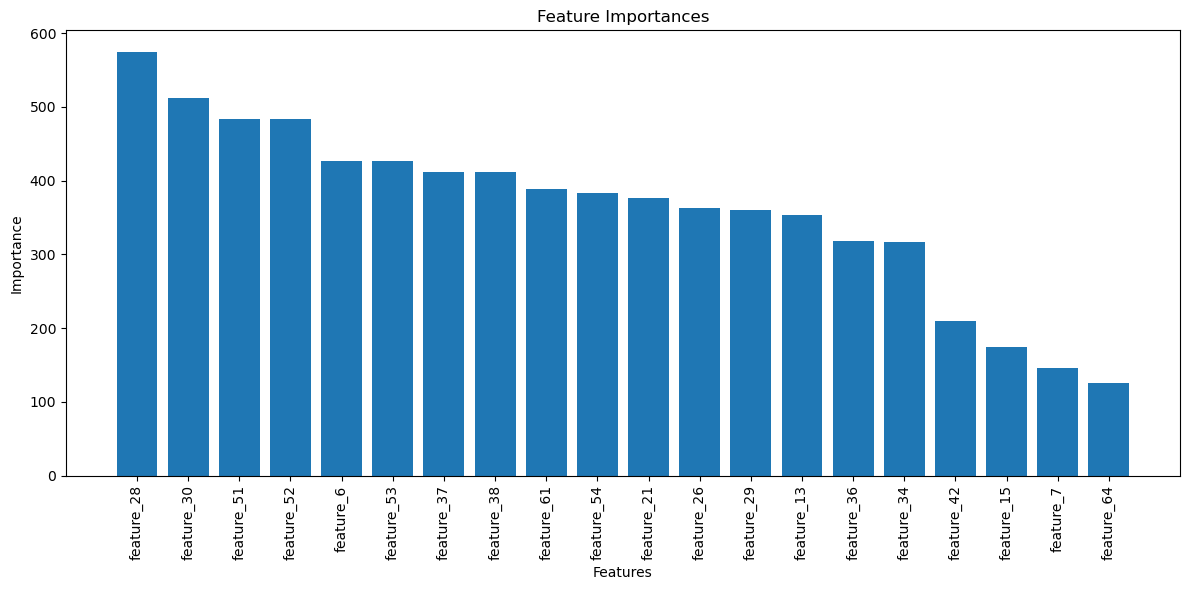

In [45]:
plot_feature_importances(feature_importances, selected_features)

In [46]:
# Sving the model pipline
joblib.dump(best_model_pipeline, '../model/best_model_pipeline.joblib')

['../model/best_model_pipeline.joblib']

In [47]:
# # Load the model pipeline
# loaded_model = joblib.load('../model/best_model_pipeline.joblib')
# # Make predictions
# y_pred = loaded_model.predict(X_test)
# y_pred

<h2 style="color:blue" align="center">Model Performance Metrics</h2>

In this section, I seek to access and discuss the performance of the model. This section will include:
<ol>
    <li>Confussion Matrix</li>
    <li>Classification Report</li>
</ol>

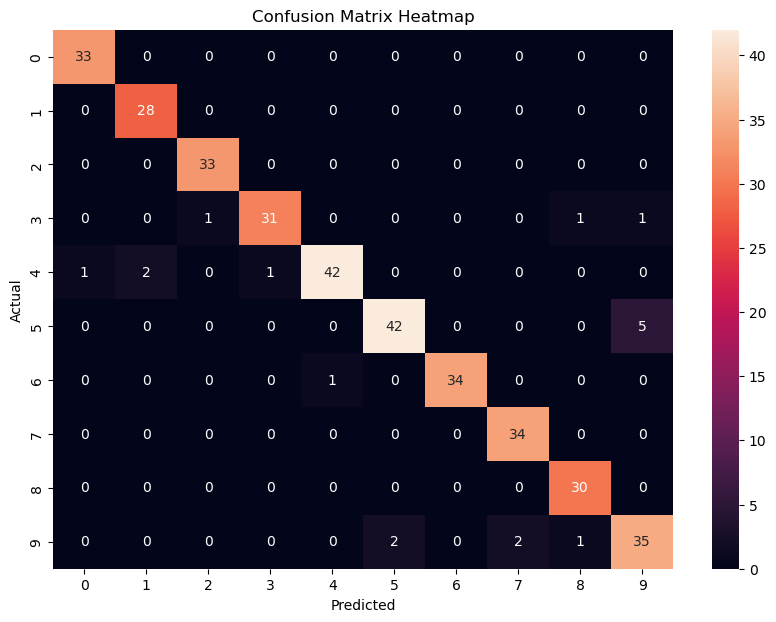

In [48]:
confusion_matrix_heatmap(y_test, y_pred)

**Most of the off-diagonal elements are zeros, which shows that the predicted differs from the acctual on <br> very few occasions, indicating that the model performed well.** 

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.93      1.00      0.97        28
           2       0.97      1.00      0.99        33
           3       0.97      0.91      0.94        34
           4       0.98      0.91      0.94        46
           5       0.95      0.89      0.92        47
           6       1.00      0.97      0.99        35
           7       0.94      1.00      0.97        34
           8       0.94      1.00      0.97        30
           9       0.85      0.88      0.86        40

    accuracy                           0.95       360
   macro avg       0.95      0.96      0.95       360
weighted avg       0.95      0.95      0.95       360

